# Plot 1240K SNPs along the genome

In [13]:
import numpy as np
import os as os
import sys as sys
import multiprocessing as mp
import pandas as pd
import socket
import shutil as shutil
import matplotlib.pyplot as plt
import h5py
from matplotlib import gridspec

socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

#sys.path.append("./package/")  # Since now we are in the Root Directory.
sys.path.insert(0,"./package/")  # Hack to get developer package
#from hmm_inference import HMM_Analyze   # Do not move. Should be after sys.path..

sys.path.append("./Notebooks/Mosaic1000G_Analysis/mosaic_test/")  # Assume we are in Hapsburg Root Directory
#from hmm_inference import HMM_Analyze   # Do not move. Should be after sys.path..

from load_funcs import Summary_ROH_Calls

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
rcParams['font.sans-serif'] = ['Arial']  # Make sure to have the font installed (it is on cluster for Harald)

midway2-0407.rcc.local
Midway jnovmbre partition detected.
/project2/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


In [2]:
output_prefix = "merged/"   #"ROHin100/" #"ROHin50/" prefix_out = "e01rohin300/" diploidGT/
#mosaic_folder = "./Simulated/1000G_Mosaic/TSI5/lambda_rc2.0/"
mosaic_folder = "./Simulated/1000G_Mosaic/TSI5/"
bl_lens = [2, 4, 6, 8, 10]
bl_focus = 0 # To show background rate
ch=3
nr_iid=100

roh = Summary_ROH_Calls(mosaic_folder=mosaic_folder, ch=ch, nr_iid = nr_iid, 
                        blen_cm = bl_focus, output_prefix = output_prefix, output=1)
df_call_fp = roh.collect_fp_df()

In [83]:
### Load the Map Positions
def load_map(path_map = "./Simulated/1000G_Mosaic/TSI5/ch3_0cm/output/iid0/chr3/map.csv"):
    """Load and return Map Positions"""
    df_map = pd.read_csv(path_map, sep=",", header=None)  # Load the Meta File
    map_pos = df_map[0].values
    return map_pos

def prep_false_positive_blocks(df_call_fp, min_m=0.01, step=0.005):
    """Prepare False Positive Blocks.
    Returns bins and counts in there"""
    dft = df_call_fp[df_call_fp["lengthM"]>min_m]
    starts = dft["StartM"].values
    ends = dft["EndM"].values

    ### Create the Binned Statistic
    bins10 = np.arange(min(map_pos), max(map_pos), step=step)  # 0.1 cM Bins
    counts = np.zeros(len(bins10), dtype="int")

    for i in range(len(starts)):
        i1 = np.searchsorted(bins10, starts[i])
        i2 = np.searchsorted(bins10, ends[i])
        counts[i1:i2] = counts[i1:i2]+1 # Add one to the counter
    return bins10, counts

def plot_fp_chrom(bins10, counts=[], map_pos=[], ax=0, figsize=(12,6), 
                  xlim=[], ylim=[-0.1, 8] ,fs = 14, 
                  ylabel="Nr FP Blocks in 0.5 cM Bins", 
                  ylabel1="NR SNPs per 0.5 cM", xlabel="Map Position [Morgan], (Chromosome 3)",
                  c1 = "darkgray", c2 = "red", show=True, savepath="", ms=1):
    """Plot False Positive Rate along one Chromosome"""
    
    if ax==0:
        plt.figure(figsize=figsize)
        ax = plt.gca()
          
    ax.set_xlim((min(map_pos), max(map_pos)))
    
    if len(counts)>0:
        ax.plot(bins10, counts, color=c1)
        ax.tick_params(axis='y', labelcolor=c1)
        ax.set_ylim(ylim)
        ax.set_ylabel(ylabel, fontsize=fs, color=c1)

    ax1 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    n, b = np.histogram(map_pos, bins = bins10)
    x = (b[1:] + b[:-1]) / 2

    ax1.plot(x, n, 'o', color=c2, ms=ms)
    ax1.tick_params(axis='y', labelcolor=c2)
    ax1.set_ylim([-1, 800])
    ax1.set_ylabel(ylabel1, color=c2, rotation=270, labelpad=fs*1.4, fontsize=fs)

    ax.set_xlabel(xlabel, fontsize=fs)
    
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0, dpi=600)
        print(f"Saved to {savepath}")
    
    if show:
        plt.show()
        
        
def plot_snp_chrom(bins10, map_pos=[], ax=0, figsize=(12,6), 
                   xlim=[], ylim=[-0.1,800] ,fs = 14,  
                   ylabel="NR SNPs per 0.5 cM", ms=1,
                   left=True, bottom=True, text="", textxy=[0.05,0.95],
                   xlabel="Map Position [Morgan], (Chromosome 3)",
                   c="red", show=True, savepath=""):
    """Plot False Positive Rate along one Chromosome"""
    
    if ax==0:
        plt.figure(figsize=figsize)
        ax = plt.gca()
          
    ax.set_xlim((min(map_pos), max(map_pos)))

    n, b = np.histogram(map_pos, bins = bins10)
    x = (b[1:] + b[:-1]) / 2

    ax.plot(x, n, 'o', color=c, ms=ms)
    ax.set_ylim(ylim)
    if len(xlim)>0:
        ax.set_xlim(xlim)
    ax.set_ylabel(ylabel, color=c, rotation=270, labelpad=fs*1.4, fontsize=fs)
    
    ax.set_xlabel(xlabel, fontsize=fs)
    
    if not left:
        ax.axes.yaxis.set_ticklabels([])
    if not bottom:
        ax.axes.xaxis.set_ticklabels([])
    
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0, dpi=600)
        print(f"Saved to {savepath}")
        
    if len(text)>0:
        ax.text(textxy[0], textxy[1], text,
             horizontalalignment='left',
             verticalalignment='top',
             transform = ax.transAxes)
    
    if show:
        plt.show()

# Plot False Positives along Chromosome 3

Saved to ./figures/manuscript/supplement/1240k_snps/chrom3_1240k_fp.pdf


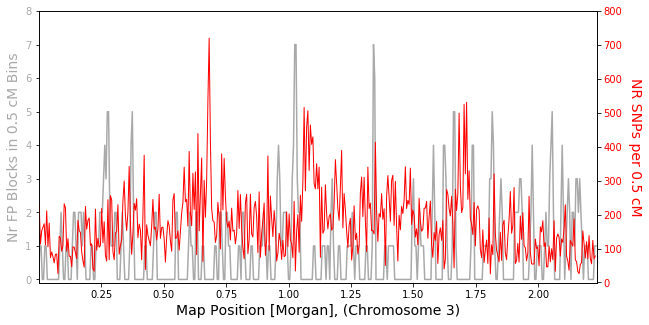

In [7]:
map_pos = load_map(path_map = "./Simulated/1000G_Mosaic/TSI5/ch3_0cm/output/iid0/chr3/map.csv")
bins10, counts = prep_false_positive_blocks(df_call_fp, min_m=0.01, step=0.005)
plot_fp_chrom(bins10, counts=counts, map_pos=map_pos, figsize=(10,5),
              savepath="./figures/manuscript/supplement/1240k_snps/chrom3_1240k_fp.pdf")

# Plot False Positive Rate for whole genome

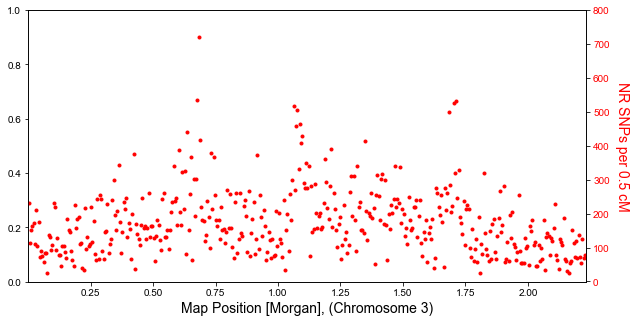

In [150]:
map_pos = load_map(path_map = "./Simulated/1000G_Mosaic/TSI5/ch3_0cm/output/iid0/chr3/map.csv")
bins10, counts = prep_false_positive_blocks(df_call_fp, min_m=0.01, step=0.005)
plot_fp_chrom(bins10, counts=[], map_pos=map_pos, figsize=(10,5), ms=3,
              savepath="") # ./figures/manuscript/supplement/1240k_snps/chrom3_1240k_fp.pdf

In [154]:
def plot_snp_density_genome(figsize=(9,10), xlim=[0,2.9], ms=1.5,
                            step=0.005, ylim=[-5, 750], fs=12,
                            xlabel = "Map Position [Morgan]",
                            ylabel = "Nr SNPs per 0.5 cM bin",
                            savepath=""):
    """Plot SNP Density along Genome"""
    fig  = plt.figure(figsize=figsize)
    
    gs = gridspec.GridSpec(11, 2, hspace=0.12, wspace=0.03)
    # height_ratios=height_ratios
    #gs.update() # set the spacing between axes. 
    
    for ch in range(1,23):
        y = (ch-1) % 2
        x = int((ch-1)/2)
        ax = plt.subplot(gs[x,y]) # The lower subplot        
        path_map = f"./E/1000G_Mosaic/TSI5/ch3_0cm/output/iid0/chr{ch}/map.csv"
        path_h5 = f"./Data/1000Genomes/HDF5/1240kHDF5/all1240int8/chr{ch}.hdf5"
        
        with h5py.File(path_h5, "r") as f: # Load for Sanity Check. See below!
            #print(f"Loaded HDF5 Chr {ch}")
            map_pos = f["variants/MAP"][:]
        bins10 = np.arange(0, np.max(map_pos), step)
        
        if y>0:
            left=False
        else:
            left=True
            
        if x<10:
            bottom=False
        else:
            bottom=True
        
        text = f"Chromosome {ch}"
        
        plot_snp_chrom(map_pos=map_pos, ms=ms,
                       ax = ax, bins10=bins10, xlim=xlim,
                       xlabel="", ylabel="", ylim=ylim,
                       left=left, bottom=bottom, fs=fs,
                       text=text, textxy=[0.69,0.93],
                       savepath="", show=False)
        
    fig.text(0.5, 0.08, xlabel, ha='center', fontsize=fs)
    fig.text(0.07, 0.5, ylabel, va='center', rotation='vertical', fontsize=fs)

    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0, dpi=600)
        print(f"Saved to {savepath}")

    plt.show()

Saved to ./figures/manuscript/supplement/1240k_snps/snp1240K.pdf


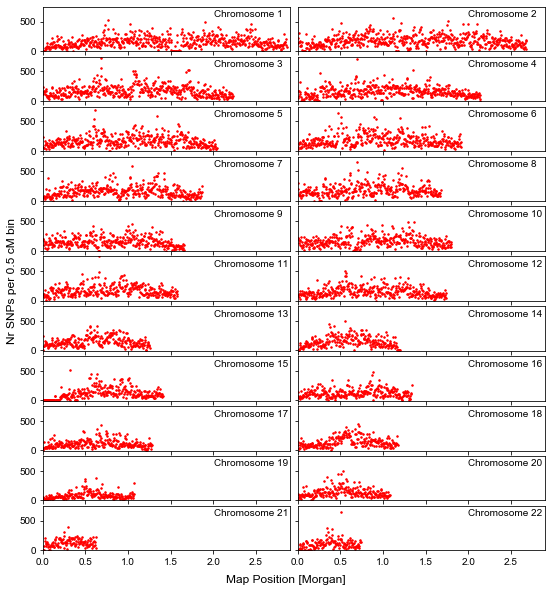

In [155]:
plot_snp_density_genome(savepath= "./figures/manuscript/supplement/1240k_snps/snp1240K.pdf")

# Area 51

In [20]:
ch = 3
path_h5 = f"./Data/1000Genomes/HDF5/1240kHDF5/all1240int8/chr{ch}.hdf5"
with h5py.File(path_h5, "r") as f: # Load for Sanity Check. See below!
    print("Loaded HDF5")
    map_pos = f["variants/MAP"][:]

Loaded HDF5


In [21]:
map_pos

array([2.400000e-05, 4.000000e-05, 8.900000e-05, ..., 2.232514e+00,
       2.232555e+00, 2.232573e+00], dtype=float32)

In [15]:
ch=2
f"./Data/1000Genomes/HDF5/1240kHDF5/all1240int8/chr{ch}.hdf5"

'./Data/1000Genomes/HDF5/1240kHDF5/all1240int8/chr2.hdf5'